# Summary
As a recent graudate struggling in the job market, I decided to make my job hunting experience a bit easier through analysis on the data scraped from https://www.seek.com.au/ within the last 3 months (2020-10 to 2021-01). The data set I collected contains over 80,000 job listings across 29 industries.
In this project, we're going to look at the following features of the job market in Australia over the last 3 months.
- Buzzwords in each industry 
- Industries that emphasizes certain soft skills, such as teamwork, communication skills and experience.
- Given a list of skills, find the 5 best matched job listings.
- Visualising the job description of different positions of an industry in 2D
- Top hiring companies in an industry
- Most popular jobs in each industry 
- Cities with high demand in an industry

In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [2]:
import sys
sys.path.append('../alchemy_mod/')
from alchemy import *

In [3]:
from preprocess_text import *

[nltk_data] Downloading package punkt to /Users/chenlang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenlang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Unimport a module
#sys.modules.pop('preprocess_text')

In [4]:
# Connect with database
engine = make_connection('scrap')

In [5]:
# Importing the data
q = "select * from seek;"
seek_df = make_query(engine, q)

#### Extracting 'industry' and 'job_category' from each job listing. 

In [6]:
my_list = seek_df['job_classification'].unique()

In [7]:
industries = ['Healthcare & Medical', 'Accounting','Community Services & Development','Trades & Services',
            'Retail & Consumer Products','Science & Technology','Mining, Resources & Energy',
            'Manufacturing, Transport & Logistics','Construction','Information & Communication Technology',
            'Real Estate & Property','Call Centre & Customer Service','Hospitality & Tourism',
            'Engineering','Legal','Education & Training','Sales','Insurance & Superannuation',
            'Administration & Office Support','Banking & Financial Services','Marketing & Communications',
            'Farming, Animals & Conservation', 'Government & Defence','Advertising, Arts & Media',
            'Design & Architecture','Human Resources & Recruitment','CEO & General Management',
            'Consulting & Strategy','Sport & Recreation']

In [8]:
def head_tail(sample_title):
    # Function to retrieve the industry and job category from a job classification
    # E.g 'Sport & Recreation, Coaching & Instruction' -> 'Sport & Recreation‘,  'Coaching & Instruction'
    my_list = []
    for item in industries:
        if sample_title.startswith(item):
            head = item
            my_list.append(head)
            tail = sample_title[len(head)+2:]
            my_list.append(tail)
    return my_list

def industry(sample_title):
    return head_tail(sample_title)[0]
def job_category(sample_title):
    return head_tail(sample_title)[1]

In [9]:
# Creating a new column for industry   E.g. "Information & Communication Technology, Developers/Programmers" 
seek_df['industry'] = seek_df['job_classification'].apply(lambda x : industry(x))

In [10]:
# Creating a new column for job category  E.g. 'Healthcare & Medical, Nursing - A&E, Critical Care & ICU'
seek_df['job_category'] = seek_df['job_classification'].apply(lambda x : job_category(x))

In [12]:
def select_industry (industry):
    # Function to select data points from given industry 
    industry_df = seek_df[seek_df['industry']==industry]
    industry_df.reset_index(drop=True, inplace = True)
    return industry_df

In [13]:
def select_job_category(df, job_category):
    # Function to select data points from given job_category 
    my_df = df[df['job_category'] == job_category]
    my_df.reset_index(drop=True, inplace = True)
    return my_df

## Keywords in each industry 
[Reference](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76）
- This section aims at finding the keywords of a given industry and plotting a wordcloud. 
- Instead of ranking the importance of a word simply based on its Term Frequency (TF) within the a piece of text. We look at the TF-IDF value of a word.
- TF: The number of times a word appears in a document divded by the total number of words in the document.
- IDF: The log of the number of documents divided by the number of documents that contain the word w. Rare words have high IDF, and stopwords have low IDF.
- TF-IDF = TF * IDF 
- Why TF-IDF? TF-IDF quantifies the importance of a word in the document. We want words that occur frequently only in the industry we're investigating, but not in other industries. If we simply use TF, some stopwords such as 'the', 'of' may be the most occurring words, but not representative of the industry. IDF for stopwords are small, which prevents their TF-IDF from getting big. 

In [16]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

In [306]:
def plot_wordCloud(my_dict, industry):
    # Function to plot the keywords retrieved 
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=20, relative_scaling=0.5,
                   normalize_plurals=False).generate_from_frequencies(my_dict)
    plt.title("Wordcloud for " + industry) 
    plt.imshow(wc)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
def TF_IDF(documentA, documentB):
    # documentA is a signle doc, documentB is a list of docs, the more the better
    my_list = [documentA, *documentB]
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(my_list)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    return df

In [20]:
def merge_strings(str_list):
    merged = ''
    for item in str_list:
        merged = merged + item + " "
    return merged

In [21]:
match_dict ={'Healthcare & Medical' : "Community Services & Development",
"Community Services & Development" : 'Healthcare & Medical',
'Trades & Services' : 'Construction',
'Accounting' : 'Banking & Financial Services',
'Retail & Consumer Products' : 'Sales',
'Science & Technology' : 'Engineering',
'Mining, Resources & Energy' : 'Construction',
'Manufacturing, Transport & Logistics' : 'Construction',
'Construction' : 'Trades & Services',
'Information & Communication Technology' : 'Engineering',
'Real Estate & Property' : 'Sales',
'Call Centre & Customer Service' : 'Hospitality & Tourism',
'Hospitality & Tourism' : 'Call Centre & Customer Service',
'Engineering' : 'Information & Communication Technology',
'Legal' : 'Administration & Office Support',
'Education & Training' : 'Human Resources & Recruitment',
'Sales' : 'Hospitality & Tourism',
'Insurance & Superannuation' : 'Sales',
'Administration & Office Support' : 'Call Centre & Customer Service',
'Banking & Financial Services' : 'Accounting',
'Marketing & Communications' : 'Advertising, Arts & Media',
'Farming, Animals & Conservation' : 'Mining, Resources & Energy',
'Government & Defence' : 'Consulting & Strategy',
'Advertising, Arts & Media' : 'Marketing & Communications',
'Design & Architecture' : 'Marketing & Communications',
'Human Resources & Recruitment' : 'CEO & General Management',
'CEO & General Management' : 'Human Resources & Recruitment',
'Consulting & Strategy' : 'Human Resources & Recruitment',
'Sport & Recreation' : 'Hospitality & Tourism'}

In [22]:
def pick_against(industry):
    # Function to pick the against_industry in TF_IDF 
    for item in list(match_dict.keys()):
        if industry == item:
            return match_dict[item]

In [126]:
def get_keywords(industry):
    # Create a function to get keywords of given industry
    
    against_industry = pick_against(industry)
    industry_df = select_industry(industry)
    print('Merging...', industry)
    industry_jobs = merge_strings(industry_df['job_description'].tolist())
    # against_industry jobs description list 
    against_industry_df = select_industry(against_industry)
    against_industry_list = against_industry_df['job_description'].tolist()
    print('TF_IDF...')
    df=TF_IDF(industry_jobs, against_industry_list)

    my_columns = df.columns.tolist()
    stop_words = set(stopwords.words("english"))
    extra_stopwords=['us','within','want','best', 'work', 'help', 'part', 'opportunity', 'across', 'working',
                 'meet','ltd']
    stop_words |= set(extra_stopwords)
    
    my_stopwords = set(my_columns) & stop_words
    print('Dropping...')
    df.drop(list(my_stopwords), axis=1, inplace=True)
    
    # Sorting the dataframe columns by first row value
    print('Sorting...')
    dfObj = df.sort_values(by = 0, axis=1, ascending=False)
    
    top_columns = dfObj.columns.tolist()[:20]
    my_row = dfObj.iloc[0] # I need to find out the TF_IDF value for each word 
    my_dict = {}
    for item in top_columns:
        my_dict[item] = my_row[item]   
    return my_dict

In [ ]:
# Getting the keywords dictionary from all industries
industry_keywords = dict()
for item in industries:
    my_keywords = get_keywords(item)
    industry_keywords[item] = my_keywords  

In [307]:
def plot_wordscloud(industry):
    my_dict = industry_keywords[industry]
    plot_wordCloud(my_dict, industry)   

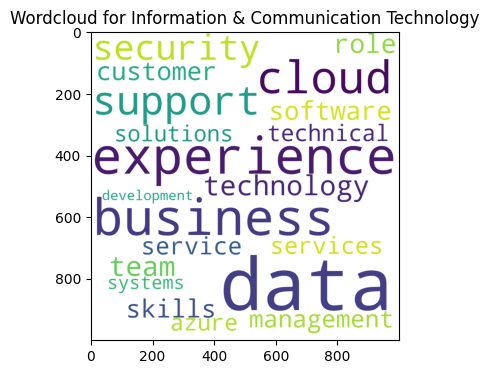

In [308]:
plot_wordscloud('Information & Communication Technology')

#### Observation
The wordcloud shows that buzzwords in the IT industry are 'data','experience', 'business', 'cloud', etc.

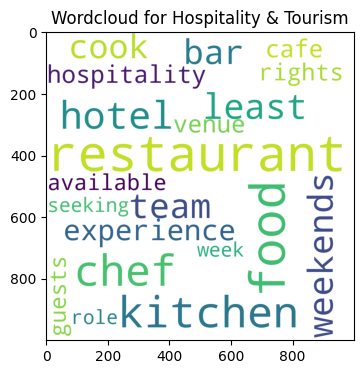

In [309]:
# Another example
plot_wordscloud('Hospitality & Tourism')

In [310]:
industry_keywords['Hospitality & Tourism']

{'restaurant': 0.1911163652948831,
 'food': 0.1790288203021015,
 'kitchen': 0.1420006192823444,
 'chef': 0.1407055593986755,
 'hotel': 0.10993053026460485,
 'least': 0.0921341218128616,
 'weekends': 0.0891154287855466,
 'team': 0.0880496731497915,
 'bar': 0.08675856480275386,
 'cook': 0.08378555567883854,
 'experience': 0.082416345804452,
 'hospitality': 0.07895864805835702,
 'cafe': 0.07878468257029338,
 'venue': 0.07758080501091354,
 'rights': 0.0734042041214918,
 'guests': 0.06678508802841644,
 'available': 0.06482881168476899,
 'seeking': 0.06457460092527842,
 'week': 0.06396544853847232,
 'role': 0.062313303271508635}

#### Observation
The wordcloud shows that buzzwords in Hospitality & Tourism are 'restaurant','food', 'kitchen', 'chef', 'hotel' etc.

## For certain keywords regarding soft skills, such as 'team', 'people', 'experience', see which industry emphasizes it most


In [292]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [311]:
def horizontal_barChart(y_list, x_list, title, x_label):
    plt.rcParams["figure.figsize"] = (7,4)
    plt.barh(y_list, x_list)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

In [133]:
industries = seek_df['industry'].unique()

In [254]:
# After going through the 20 keywords for each industry, I picked the following common key words for soft skills. 
picked_words = ['team', 'experience', 'skill', 'service','customer','ability','people',
                'client','management','customer','safety',
                'business','client']

In [258]:
# Creating a dictionary to show how much each industry stresses a given word.
main_dict = dict()
for my_word in picked_words:
    word_dict = dict()
    for industry in industries:
        industry_dict = industry_keywords[industry]
        if my_word in industry_dict :
            word_dict[industry] = industry_dict[my_word]
        if (my_word+'s') in industry_dict:
            if industry in word_dict:
                word_dict[industry] = industry_dict[my_word+'s'] + word_dict[industry]
            else:
                word_dict[industry] = industry_dict[my_word+'s']
                          
    main_dict[my_word] = word_dict              

In [295]:
def plot_word_industry(my_word):
    people_dict = main_dict[my_word]
    # Sort the dictionary and plot it 
    people_dict = dict(sorted(people_dict.items(), key=lambda item: item[1]))
    people_keys = list(people_dict.keys())
    people_values = list(people_dict.values())
    
    title = 'Industries emphasizing ' + my_word
    horizontal_barChart(people_keys, people_values, title, 'TF-IDF values')
     

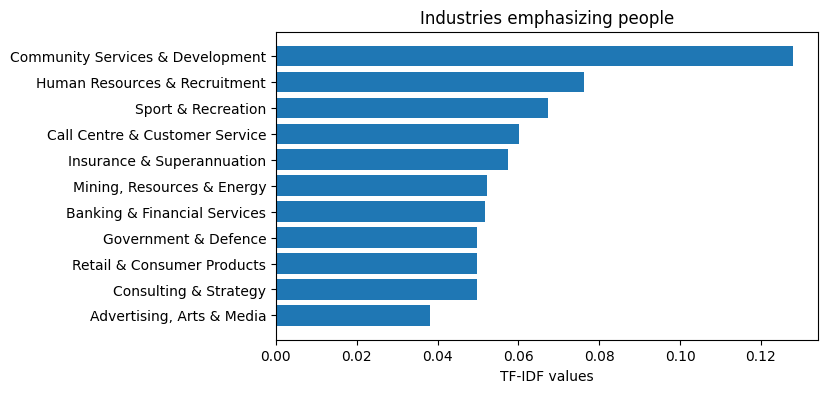

In [388]:
plot_word_industry('people')

#### Observation
The barchart shows that 'Real Estate & Property', 'Construction' and 'CEO & General Management' emphasizes management skills a lot.

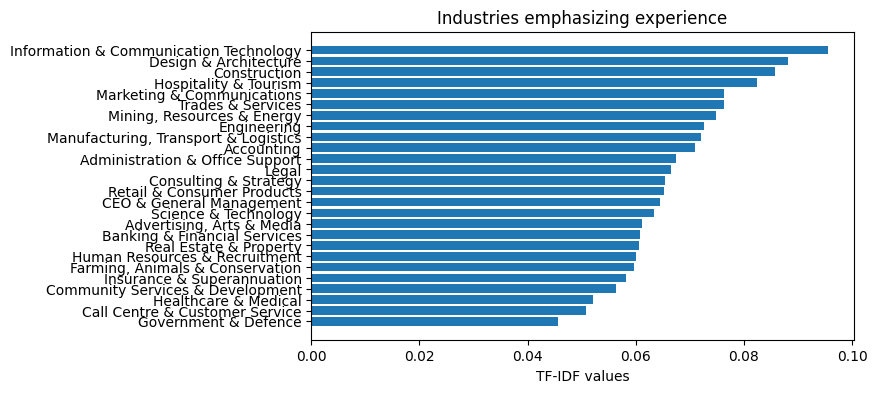

In [387]:
plot_word_industry('experience')

#### Observation
The barchart shows that good service is highly emphasized in 'Call Centre & Customer Service', 'Community Services & Development' and 'Information & Communication Technology'. 

## Within an industry, given a list of skills, find the 5 best matched job listings.
It returns the ID of the job listings, so that we can search the job listing by URL, e.g. 'https://www.seek.com.au/job/51386461'

In [317]:
IT_df = select_industry('Information & Communication Technology')
train_corpus = IT_df['job_description'].tolist()
bigram = get_bigram(train_corpus)

In [325]:
def match_skills (bigram, my_skills, job_description):
    "Function to return a list of matched skills, given a list of skills and a job description"
    cleaned_job_description = clean_str(bigram, job_description)
    cleaned_job_set = set(cleaned_job_description)
    lower_case_skills = [item.lower() for item in my_skills]
    return set(lower_case_skills) & cleaned_job_set

def earliest_day():
    # Function to find the earlies date of existing job listings, coz on seek it only shows jobs posted within the last 30 days.
    today = date.today()
    n_days_ago = today - timedelta(days=30)
    return n_days_ago

def match_jobs (IT_df, my_skills):
    # Function to return a list of JobID of job listings matching the given skill sets.
    train_corpus = IT_df['job_description'].tolist()
    bigram = get_bigram(train_corpus)
    # Getting the data within recent 30 days
    n_days_ago = earliest_day()
    recent_df = IT_df[IT_df['job_listing_date'] > n_days_ago]

    recent_df['matched_skills'] = recent_df['job_description'].apply(lambda x : match_skills(bigram, my_skills, x))
    recent_df['skills_num'] = recent_df['matched_skills'].apply(lambda x : len(x))

    a_df = recent_df.sort_values(by='skills_num', ascending=False)
    return a_df.head(5)['JobID'].tolist()

def match_my_skills(industry, my_skills):
    IT_df = select_industry(industry)
    train_corpus = IT_df['job_description'].tolist()
    bigram = get_bigram(train_corpus)
    
    return match_jobs (IT_df, my_skills)  

In [340]:
my_skills = ['Node','RxJS','Javascript','angular']
matched_jobIDs = match_my_skills("Information & Communication Technology", my_skills)

# Printing the job titles of the matched job listings
print('Job titles of the jobs matching my skills 🤓 🛠: '+ str(my_skills))
print()
for item in matched_jobIDs:
    job_title = seek_df[seek_df['JobID']== item]['job_title'].to_list()[0]
    print(job_title)

Job titles of the jobs matching my skills 🤓 🛠: ['Node', 'RxJS', 'Javascript', 'angular']

Mid- Level Full Stack Developer - Banking Software - 85618/ 85619
Front End Website Developer at Award Winning Social Media Agency
Senior Developer 
Software Developer
Senior Developer Engineer


<ipython-input-325-3dd5434d7654>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_df['matched_skills'] = recent_df['job_description'].apply(lambda x : match_skills(bigram, my_skills, x))
<ipython-input-325-3dd5434d7654>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_df['skills_num'] = recent_df['matched_skills'].apply(lambda x : len(x))


## Visualising the job description of different positions in 2D
 - By visualising the job description within one industry, we can understand how different job positions within the same industry overlap with or differ from each other. It allows more flexibility for us when looking for jobs, so that we don't have to be restricted to one or 2 job categories. 

How to do it?
- We convert job description as text to vector using Doc2Vec algorithm
- Reduce the dimension of the vector to 2D for visualisation with TSNE algorithm

In [381]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import random
import logging
import os
import gensim
from sklearn.manifold import TSNE

In [342]:
def read_corpus(lines, tokens_only=False):
    "Function to tokenize and convert line to the generator model requires for building vacabulary"
    for i, line in enumerate(lines):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [343]:
def infer_doc(job_description):
    "Function to infer a job description as vector"
    job_description_tokenized = gensim.utils.simple_preprocess(job_description)
    job_vector = model.infer_vector(job_description_tokenized)
    return job_vector

def job_vector(df):
    # Function to convert job_description to vector
    df['job_description_vector'] = df['job_description'].apply(lambda x : infer_doc(x))
    return df 

def reduce_vector(df):
    # Function to reduce the job_description vector 
    my_text = df['job_description_vector'].to_list()
    my_array = np.array(my_text)
    # Now I can use TSNE 
    a_embedded = TSNE(n_components=2).fit_transform(my_array)
    a_series = pd.Series(a_embedded.tolist())
    df['reduced_vector'] = a_series
    return df 

def reduce_dimension(df):
    # Function to reduce infer vector from job description and reduce the vector dimension 
    
    # Reading data, retireving the job_description
    print('Reading data...')
    train_corpus = df['job_description'].tolist()
    # Find the max len of job description for vector_size in model
    len_list = list()
    for line in train_corpus:
        processed_line = gensim.utils.simple_preprocess(line)
        len_list.append(len(processed_line))
    max_len = max(len_list) 
    
    # Initiate the model
    print('Initiating the model...')
    model = gensim.models.doc2vec.Doc2Vec(vector_size=max_len, min_count=2, epochs=30)
    
    print('Training the model...')
    train_lines = list(read_corpus(train_corpus,tokens_only=False))
    model.build_vocab(train_lines)
    model.train(train_lines, total_examples=model.corpus_count, epochs=model.epochs)
    
    print('Inferring vector...')
    df = job_vector(df)
    print('Reducing vector dimension...')
    df = reduce_vector(df)
    return df

def bubble_chart(df, hue_column):
    # Function to plot a bubble chart with the given classification column
    my_x = [i[0] for i in df['reduced_vector'].to_list()]
    my_y = [i[1] for i in df['reduced_vector'].to_list()]
    # Creating X, Y columns for plot
    df['my_x'] = my_x
    df['my_y'] = my_y
    
    new_df=df.groupby([hue_column],as_index=False).agg({'my_x':['mean','std'], 'my_y':['mean','std']})
    # 2 standard deviations as the radius
    new_df['std'] = (new_df[('my_x','std')] + new_df[('my_y','std')])*2
    
    x_list= new_df[('my_x', 'mean')]
    y_list= new_df[('my_y', 'mean')]

    new_df.drop([('my_x', 'mean'),('my_y', 'mean'),('my_x', 'std'),('my_y', 'std')],axis=1, inplace=True)
    new_df['my_x'] = x_list
    new_df['my_y'] = y_list

    #Create figure
    plt.figure(figsize = (15,10))
    # Create scatterplot. alpha controls the opacity and s controls the size.
    ax = sns.scatterplot(data=new_df, x='my_x', y='my_y', alpha = 0.5,
                         size = 'std', sizes=(200, 9000), hue =hue_column, palette='colorblind')
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.legend([],[], frameon=False)
    #For each point, we add a text inside the bubble

    for line in range(0,new_df.shape[0]):
         ax.text(new_df['my_x'][line], new_df['my_y'][line], new_df[hue_column][line],
                 horizontalalignment='center', size='medium', color='black')
            
def visualise_industry(industry_a):
    # Function to visualise the job description within a given industry in 2D
    IT_df = select_industry(industry_a)
    IT_df = reduce_dimension(IT_df)
    bubble_chart(IT_df, 'job_category')  

### Visualise the job description of different job positions within one industry

Reading data...
Initiating the model...
Training the model...
Inferring vector...


<ipython-input-343-ce430b7f0cca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['job_description_vector'] = df['job_description'].apply(lambda x : infer_doc(x))


Reducing vector dimension...


<ipython-input-343-ce430b7f0cca>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reduced_vector'] = a_series
<ipython-input-343-ce430b7f0cca>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['my_x'] = my_x
<ipython-input-343-ce430b7f0cca>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

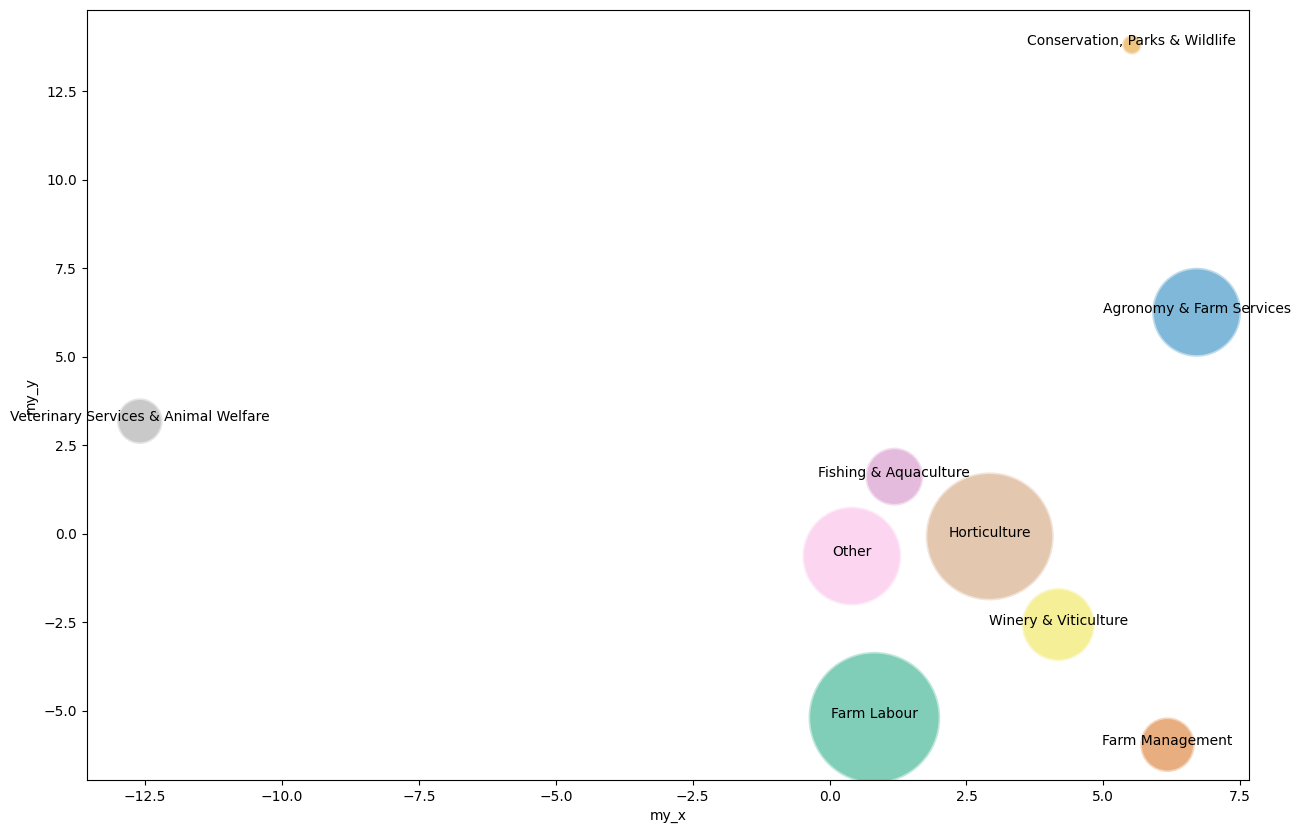

In [348]:
visualise_industry('Farming, Animals & Conservation')

#### Observation
The bubble chart of 'Farming, Animals & Conservation' shows that jobs in 'Fishing & Aquaculture', 'Horiculture', 'Winery & Viticulture', 'Farm Labor' and 'Farm Management' are similar to each other. On the contrary, 'Agronomy & Farm Services', 'Veterinary Services & Animal Welfare' and 'Conservation, Parks & Wildlife' differ from each other and the other industries.

Reading data...
Initiating the model...
Training the model...
Inferring vector...


<ipython-input-343-ce430b7f0cca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['job_description_vector'] = df['job_description'].apply(lambda x : infer_doc(x))


Reducing vector dimension...


<ipython-input-343-ce430b7f0cca>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reduced_vector'] = a_series
<ipython-input-343-ce430b7f0cca>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['my_x'] = my_x
<ipython-input-343-ce430b7f0cca>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

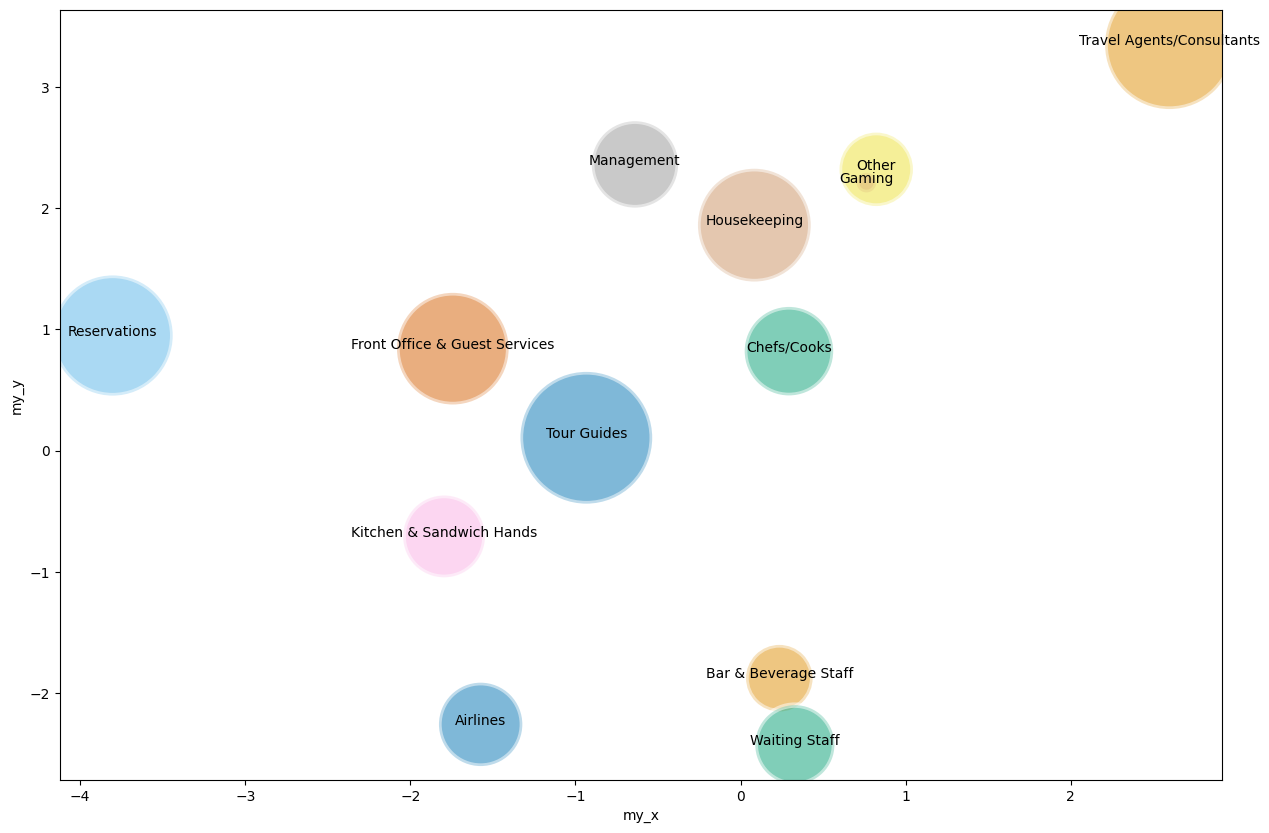

In [370]:
visualise_industry('Hospitality & Tourism')

In [366]:
industries

array(['Healthcare & Medical', 'Trades & Services',
       'Community Services & Development', 'Accounting',
       'Retail & Consumer Products', 'Science & Technology',
       'Mining, Resources & Energy',
       'Manufacturing, Transport & Logistics', 'Construction',
       'Information & Communication Technology', 'Real Estate & Property',
       'Call Centre & Customer Service', 'Hospitality & Tourism',
       'Engineering', 'Legal', 'Education & Training',
       'Banking & Financial Services', 'Marketing & Communications',
       'Sales', 'Insurance & Superannuation',
       'Administration & Office Support',
       'Farming, Animals & Conservation', 'Government & Defence',
       'Advertising, Arts & Media', 'Design & Architecture',
       'Human Resources & Recruitment', 'CEO & General Management',
       'Consulting & Strategy', 'Sport & Recreation'], dtype=object)

## Top hiring companies in an industry

In [378]:
def plot_hiring_companies(an_industry):
    industry_df = select_industry(an_industry)
    industry_df = industry_df[ industry_df['company_name'] != 'company_name None' ]
    new_df=industry_df.groupby('company_name').size().reset_index().rename(columns={0: 'Hiring counts'}).sort_values(by=['Hiring counts'],ascending=True).tail(15)
    
    
    y_list = new_df['company_name'].to_list()
    x_list = new_df['Hiring counts'].to_list()
    title = 'Top hiring companies in ' + an_industry
    
    horizontal_barChart(y_list, x_list, title, "Counts")     

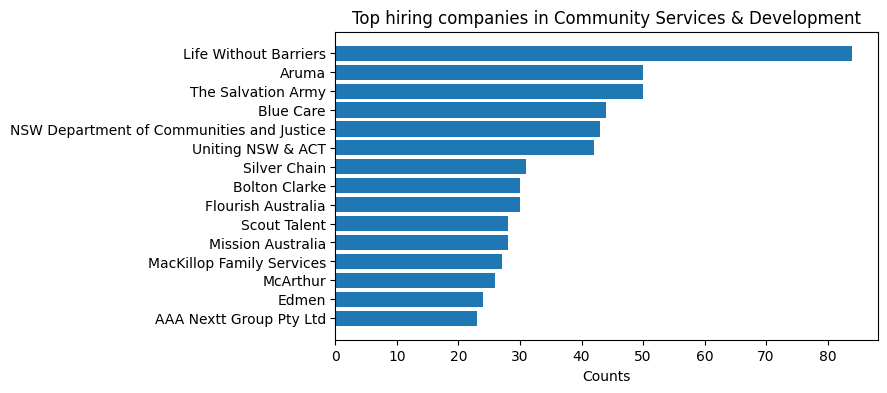

In [379]:
plot_hiring_companies('Community Services & Development')

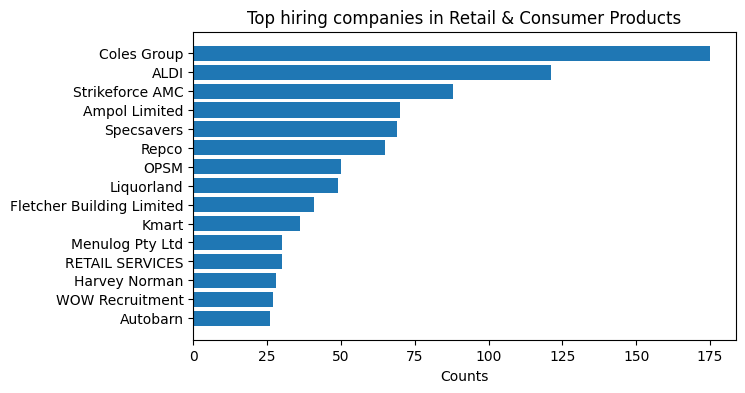

In [382]:
plot_hiring_companies('Retail & Consumer Products')

### Hiring trend for an industry over the months

In [27]:
# Convert job posting date to year-month, then group by 
seek_df['datetime'] = pd.to_datetime(seek_df['job_listing_date'])
seek_df['year_month'] = seek_df['datetime'].dt.strftime('%Y-%m')
 
def line_plot(x_list, y_list):
    plt.plot(x_list, y_list, color='skyblue')
    plt.title('Job counts each month')
    plt.xlabel('Month')
    plt.ylabel('Job Counts')
    plt.show()

In [28]:
def industry_hiring_trend(industry_a):
    # Function to plot the hiring trend of a given industry (number of job postings over each month)
    industry_df = seek_df[seek_df['industry']==industry_a]
    new_df = industry_df.groupby('year_month').size().reset_index().rename(columns={0: 'month_counts'})
    months = new_df['year_month'].to_list()
    counts = new_df['month_counts'].to_list()
    
    line_plot(months, counts)  

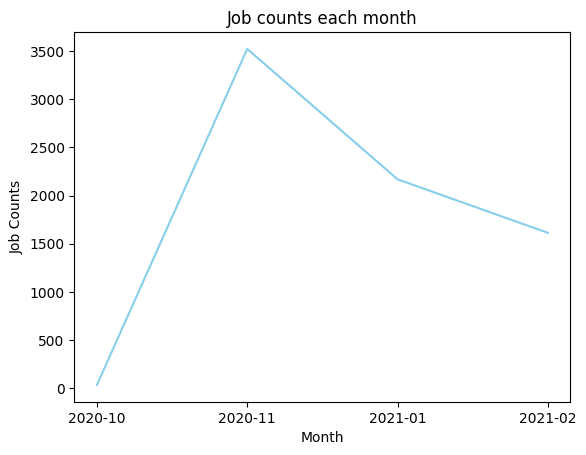

In [29]:
industry_hiring_trend('Accounting')

#### Observation
There's missing data in 2020-12, so we're gonna skip this feature.

### Most popular jobs in each industry 

In [376]:
def popular_jobs(industry_a):
    # Function to plot the number of job postings in each job category in an industry
    industry_df = select_industry(industry_a)

    new_df=industry_df.groupby('job_category').size().reset_index().rename(columns={0: 'counts'}).sort_values(by=['counts'],ascending = True).tail(10)
    
    y_list = new_df['job_category'].to_list()
    x_list = new_df['counts'].to_list()
    title = 'Popular jobs in ' + industry_a
    
    horizontal_barChart(y_list, x_list, title, "Counts")
    

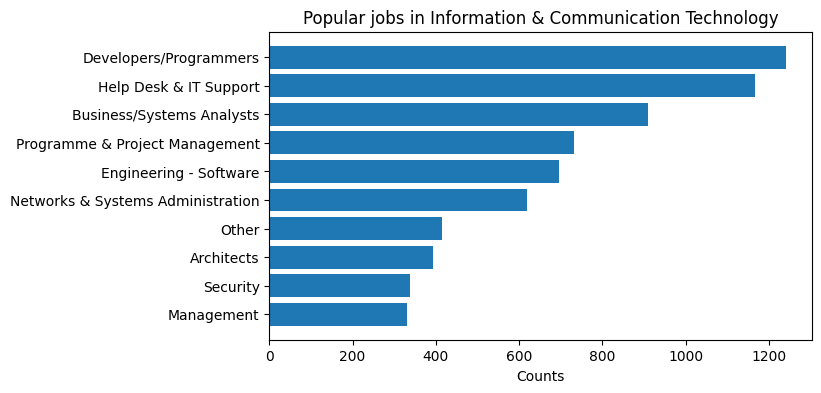

In [377]:
popular_jobs('Information & Communication Technology')

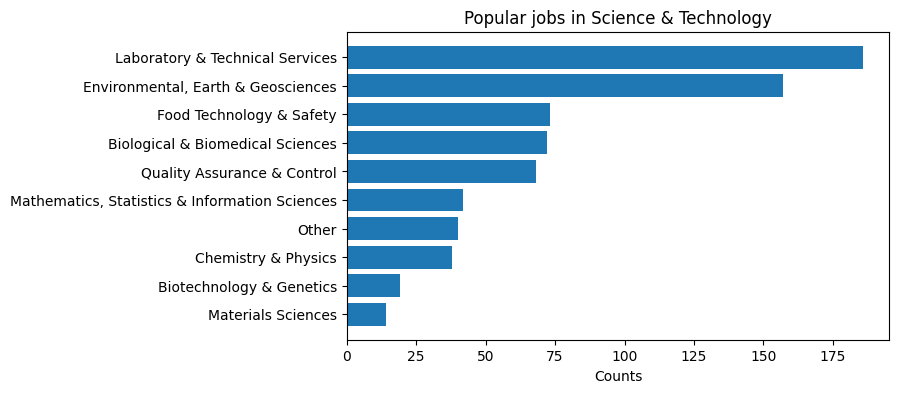

In [383]:
popular_jobs('Science & Technology')

### Locations with high demand in an industry

In [34]:
def clean_location(location):
    # Function to extract city from job_location
    return location.split(",")[0]  

seek_df['city'] = seek_df['job_location'].apply(lambda x : clean_location(x))

In [374]:
def popular_cities(industry_a):
    # Function to plot the number of job postings in a location in an industry
    industry_df = select_industry(industry_a)
    new_df=industry_df.groupby('city').size().reset_index().rename(columns={0: 'counts'}).sort_values(by=['counts'],ascending = True).tail(10)
    
    y_list = new_df['city'].to_list()
    x_list = new_df['counts'].to_list()
    title = 'Cities with high demands in ' + industry_a
    
    horizontal_barChart(y_list, x_list, title, "Counts")

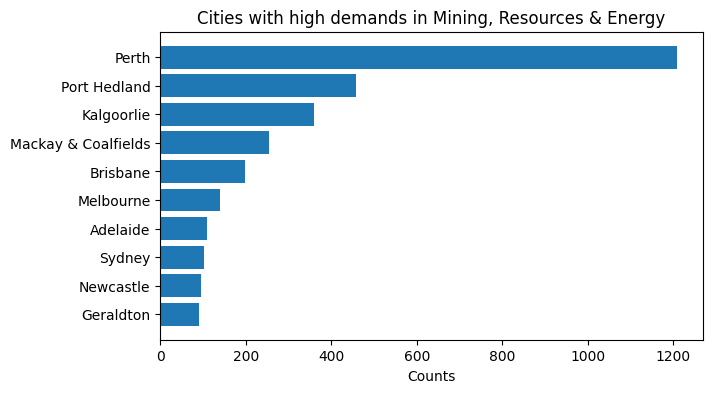

In [375]:
popular_cities('Mining, Resources & Energy')

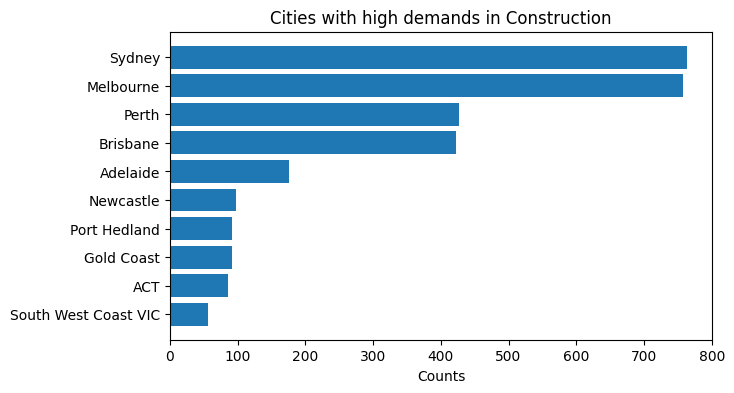

In [386]:
popular_cities('Construction')

In [385]:
seek_df['industry'].unique()

array(['Healthcare & Medical', 'Trades & Services',
       'Community Services & Development', 'Accounting',
       'Retail & Consumer Products', 'Science & Technology',
       'Mining, Resources & Energy',
       'Manufacturing, Transport & Logistics', 'Construction',
       'Information & Communication Technology', 'Real Estate & Property',
       'Call Centre & Customer Service', 'Hospitality & Tourism',
       'Engineering', 'Legal', 'Education & Training',
       'Banking & Financial Services', 'Marketing & Communications',
       'Sales', 'Insurance & Superannuation',
       'Administration & Office Support',
       'Farming, Animals & Conservation', 'Government & Defence',
       'Advertising, Arts & Media', 'Design & Architecture',
       'Human Resources & Recruitment', 'CEO & General Management',
       'Consulting & Strategy', 'Sport & Recreation'], dtype=object)